# Изучение закономерностей, определяющих успешность игр

# Описание проекта
Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и планируется кампания на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируются продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Описание данных:
 - Name — название игры
 - Platform — платформа
 - Year_of_Release — год выпуска
 - Genre — жанр игры
 - NA_sales — продажи в Северной Америке (миллионы проданных копий)
 - EU_sales — продажи в Европе (миллионы проданных копий)
 - JP_sales — продажи в Японии (миллионы проданных копий)
 - Other_sales — продажи в других странах (миллионы проданных копий)
 - Critic_Score — оценка критиков (максимум 100)
 - User_Score — оценка пользователей (максимум 10)
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
# Данные за 2016 год могут быть неполными.

# Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()
data.sample(10)
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


0

# Шаг 2. Подготовим данные

Приведём названия стобцов к нижнему регистру. Посмотрим на пропуски.

In [4]:
data.columns = data.columns.str.lower()
data.sample(1)
data.isnull().sum().sort_values()

platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
name                  2
genre                 2
year_of_release     269
user_score         6701
rating             6766
critic_score       8578
dtype: int64

Преобразуем данные в нужные типы:
- в ['year_of_release'] содержаться информация о годе релиза. Как известно, информация взята из открытых источников и каким-то образом она не поапала в файл с данными. Можем предположить, что при сборе данных какая-то информация была пропущена или её не смогли найти. Для удобства работы переведём в целочисленный. Пропуски заполним меткой. Первая компьютерная игра в мире: Tennis for Two. Она вышла в октябре 1958. Будем учитывать эту метку при работе, если понадобится.
- в ['user_score'] содержится информация об оценке пользвателей. Как известно, информация взята из открытых источников и каким-то образом она не попала в файл с данными. Можем предположить, что при сборе данных какая-то информация была пропущена или её не смогли найти. Для удобства работы переведём в число с плавающей точкой. Можно заметить необычное значение 'tbd'. Так как речь идёт о компьютерных играх, предположим, что это аббревиатура. Она не скрывает в себе никаких таинственных смыслов и расшифровывается очень просто - To Be Determined, то есть "Будет определено". А пока не определено - проставим np.nan. 0 проставить не можем, так как это значение из области определения релевантных значений

In [26]:
data['year_of_release'] = data['year_of_release'].fillna(1958)
data['year_of_release'] = data['year_of_release'].astype('int')
data.loc[data['user_score'] == 'tbd','user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')
data['user_score'].unique()

array([-1. ,  8.3,  4.3,  5.7,  5. ,  6.5,  9.1,  6.1,  7.9,  5.4,  8.1,
        6.4,  3.4,  8.5,  4.8,  4.9,  4.5,  6.2,  8.4,  6.3,  7.7,  9.2,
        7.6,  8.7,  6.7,  7. ,  4.1,  8.2,  6.8,  5.5,  7.5,  4.4,  5.9,
        7.2,  6.9,  3.9,  4.2,  3.2,  8.6,  3.1,  9. ,  7.3,  7.4,  6. ,
        4.7,  7.1,  8.8,  5.1,  6.6,  3. ,  5.8,  2.9,  8.9,  2.7,  8. ,
        3.5,  7.8,  5.2,  5.6,  4.6,  3.3,  9.3,  4. ,  3.6,  3.7,  2.4,
        2.8,  5.3,  1.7,  1.6,  3.8,  1.5,  0.7,  2.5,  2. ,  2.1,  0.2,
        1.9,  1.4,  2.3])

In [6]:
data.isnull().sum().sort_values()

platform              0
year_of_release       0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
name                  2
genre                 2
rating             6766
critic_score       8578
user_score         9125
dtype: int64

Пропуски в рейтингах и оценках:
- ['user_score'], ['critic_score'] заполнив средним или медианой можно исказить данные, заполним заглушкой для удобства работы
- ['rating'] Рейтинг присваивает Entertainment Software Rating Board (ESRB). Это негосударственная организация, основное направление которой - принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. Вероятно, организация коммерческая и локальная. Отсутствие рейтинга может быть по целому ряду причин: игра выпущена в регионе где рейтинг оценивается другой организацией; рейтинг не успели сформировать. Определить самостоятельно невозможно, заполним логически и чтобы было понятно.
- ['genre'], ['name'] всего пара пропусков, избавимся.

In [7]:
data['user_score'] = data['user_score'].fillna(-1)
data['critic_score'] = data['critic_score'].fillna(-1)
data['rating'] = data['rating'].fillna('out of rating')
data = data.dropna(subset=['name','genre'])
data.isnull().sum().sort_values()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [8]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.sample(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
11802,Legend of the Guardians: The Owls of Ga'Hoole,X360,2010,Action,0.06,0.01,0.0,0.01,60.0,8.0,E10+,0.08


# Шаг 3. Проведём исследовательский анализ данных.

Посмотрим сколько игр выпускалось в разные годы. Определим более важный период.

<AxesSubplot:title={'center':'Выпуск по годам'}, xlabel='года', ylabel='количество'>

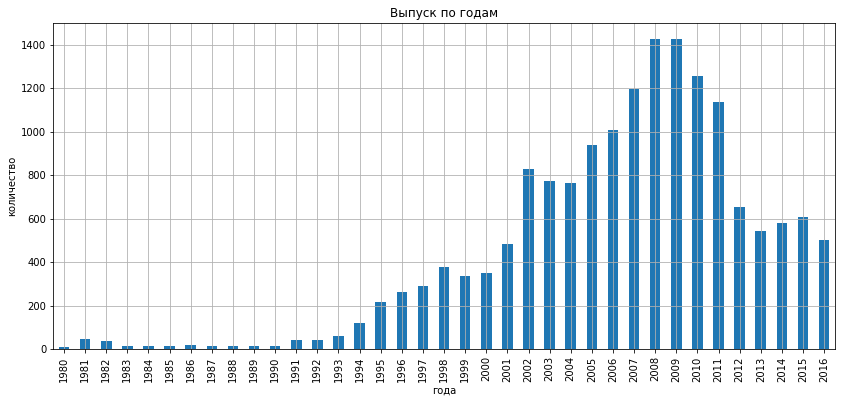

In [10]:
data_y = data[data['year_of_release'] != 1958].pivot_table(
    index=['year_of_release'], values='name', aggfunc='count').reset_index()
data_y.plot(
    kind='bar', x='year_of_release', y='name', figsize=(14,6),
    grid=True, title='Выпуск по годам', xlabel = 'года', ylabel = 'количество', legend = False)


Исходя из графика, можно отметить, что активность, хоть и не значительная, начинается после 1990го года. После 2000го года активность стремительно растёт. Пик приходится на 2008-2009 годы. Далее активность снижается.
Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.


,platform,total_sales
3,PS4,288.15
9,XOne,140.36
0,3DS,86.68
2,PS3,68.18
8,X360,48.22
7,WiiU,42.98
1,PC,27.05
5,PSV,22.40
6,Wii,5.07
4,PSP,0.36


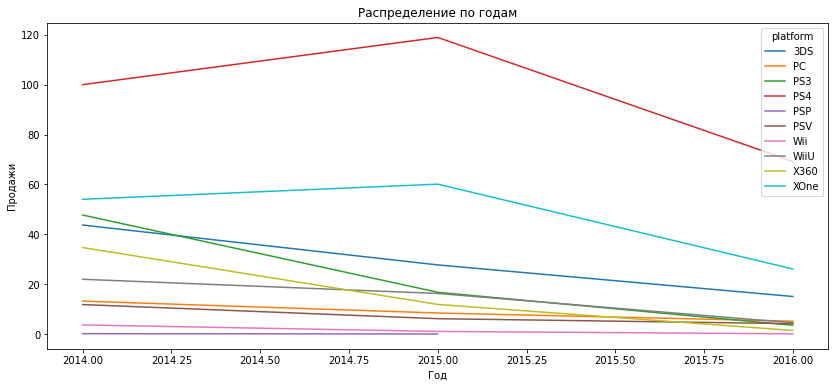

In [34]:
data_y_p = data[data['year_of_release'] > 1990].pivot_table(
    index=['platform','year_of_release'], values='total_sales', aggfunc='sum').reset_index()

platform_sales_top = data_y_p.groupby('platform').agg({'total_sales':'sum'}).reset_index()

platform_sales_top = platform_sales_top.sort_values(by='total_sales', ascending=False).head(15)

data_y_p = data_y_p.query('platform in @platform_sales_top.platform')

display(platform_sales_top)

plt.figure(figsize=(14,6))
sns.lineplot(data=data_y_p, x='year_of_release', y='total_sales', hue='platform' )
plt.title("Распределение по годам")
plt.xlabel("Год")
plt.ylabel("Продажи")
plt.show()

График показывает, что жизненный цикл у платформ в основном от 5-ти до 10-ти лет, пик приходится всего на несколько лет. Но можно отметить, что долгожителем является PC. Объяснить это можно тем, что персональный компьютер - это не просто платформа, а полноценное многофункциональное устройство. Даже если не будет игр вообще, компьютер останется.

Нам нужно выявить определяющие успешность игры закономерности для того, чтобы спланировать рекламные кампании на 2017 год. Возьмём данные за 2014, 2015 и 2016 годы.
Посмотрим, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.

,platform,total_sales
3,PS4,288.15
9,XOne,140.36
0,3DS,86.68
2,PS3,68.18
8,X360,48.22
7,WiiU,42.98
1,PC,27.05
5,PSV,22.40
6,Wii,5.07
4,PSP,0.36


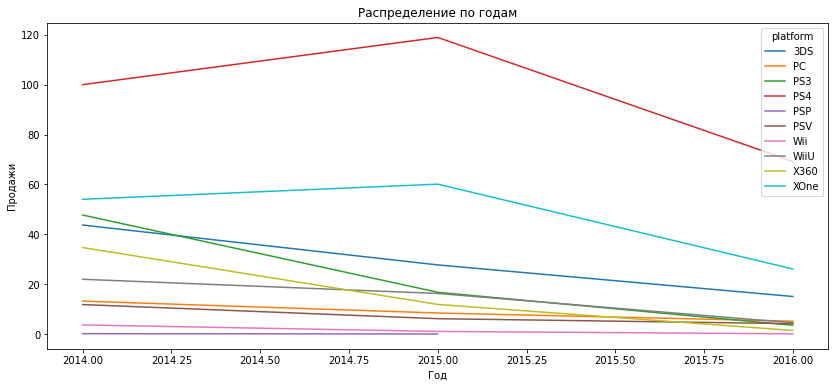

In [35]:
data_y_p = data[data['year_of_release'] > 2013].pivot_table(
    index=['platform','year_of_release'], values='total_sales', aggfunc='sum').reset_index()

platform_sales_top = data_y_p.groupby('platform').agg({'total_sales':'sum'}).reset_index()

platform_sales_top = platform_sales_top.sort_values(by='total_sales', ascending=False).head(10)

data_y_p = data_y_p.query('platform in @platform_sales_top.platform')

display(platform_sales_top)

plt.figure(figsize=(14,6))
sns.lineplot(data=data_y_p, x='year_of_release', y='total_sales', hue='platform' )
plt.title("Распределение по годам")
plt.xlabel("Год")
plt.ylabel("Продажи")
plt.show()

Видно, что активность снижается. В топ-3 входят PS4, XOne и 3DS.
Построим график по глобальным продажам игр по всем платформам за актуальный период.

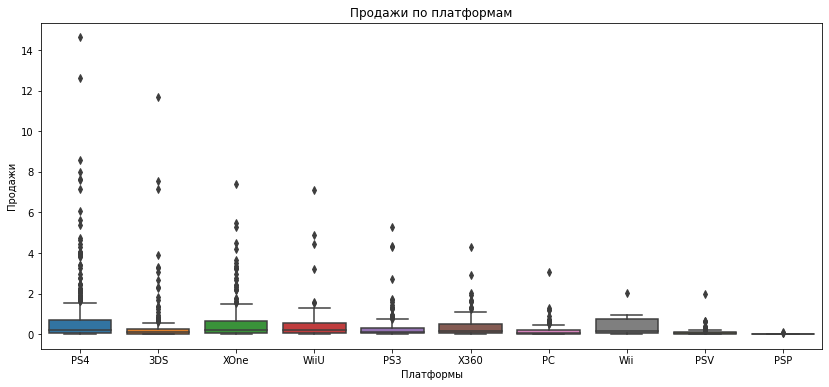

In [37]:
data_y = data[data['year_of_release'] > 2013]
plt.figure(figsize=(14,6))
sns.boxplot(data=data_y, x='platform', y='total_sales')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.title('Продажи по платформам')
plt.show()

На графике видно, что в актуальном периоде всего десять платформ. Также нужно отметить, что видно большое количество выбросов. Логично предположить, что это бестселлеры. У платформы PS4 визуально дела обстоят лучше всех. Посмотрим ближе.

,platform,total_sales
3,PS4,288.15
9,XOne,140.36
0,3DS,86.68
2,PS3,68.18
8,X360,48.22
7,WiiU,42.98
1,PC,27.05
5,PSV,22.40
6,Wii,5.07
4,PSP,0.36


(0.0, 2.0)

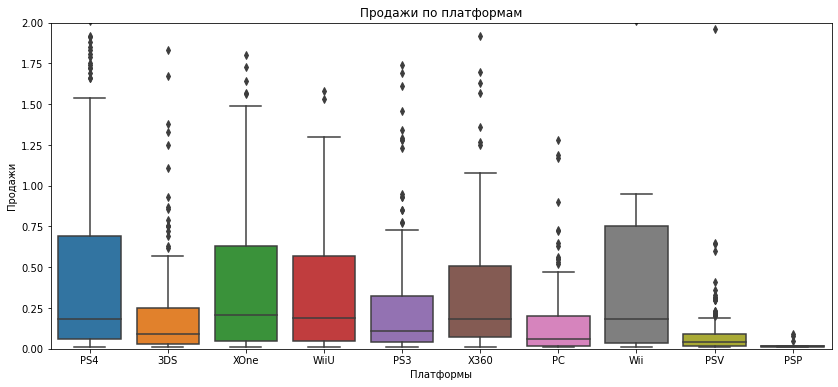

In [38]:
display(data_y.groupby('platform').agg({'total_sales':'sum'}).reset_index().sort_values(
    by='total_sales', ascending= False ))
plt.figure(figsize=(14,6))
sns.boxplot(data=data_y, x='platform', y='total_sales')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.title('Продажи по платформам')
plt.ylim(0,2)

У PS4 самый большой размах и существенно больше выбросов, бестселлеров. У Nintendo 3ds достаточно узкий межквартильный размах, значения однородны. Платформа Xbox One похожа по значениям на PS4: медиана и границы примерно на одинаковом уровне, есть выбросы, но их очевидно меньше.
Посмотрим, как влияют на продажи внутри топовой платформы PlayStation 4 отзывы пользователей и критиков. 
Построим график и посчитаем корреляцию между отзывами и продажами.

Корреляция зависимости от оценки пользователей -0.01
Корреляция зависимости от оценки критиков 0.4


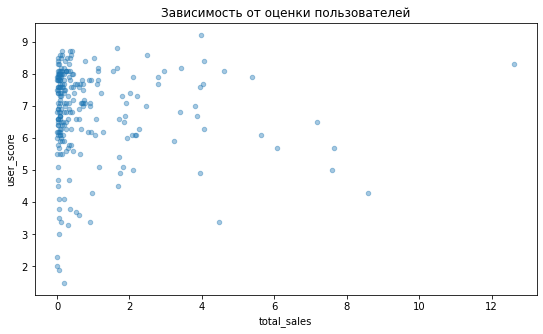

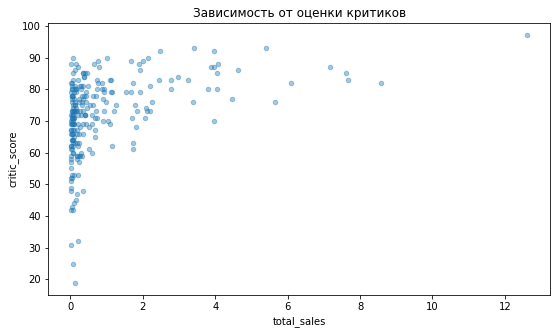

In [16]:
data_ps4 = data[(data['year_of_release'] > 2013) & (data['platform'] == 'PS4')]
data_ps4 = data_ps4[data_ps4['user_score'] != -1]
data_ps4.plot(x='total_sales', y='user_score', kind='scatter', alpha=0.4,  figsize=(9,5), title='Зависимость от оценки пользователей')

data_ps4 = data[(data['year_of_release'] > 2013) & (data['platform'] == 'PS4')]
data_ps4 = data_ps4[data_ps4['critic_score'] != -1]
data_ps4.plot(x='total_sales', y='critic_score', kind='scatter', alpha=0.4,  figsize=(9,5), title='Зависимость от оценки критиков')

                    
print('Корреляция зависимости от оценки пользователей', data_ps4['user_score'].corr(data_ps4['total_sales']).round(decimals=2))
print('Корреляция зависимости от оценки критиков',data_ps4['critic_score'].corr(data_ps4['total_sales']).round(decimals=2))

Корреляция зависимости от оценки пользователей отрицательная, но очень слабая: -0.01 . Можно предположить, что связь имеет более сложный характер. Например, отзывы одних пользователей могут и не влиять на предпочтения конкретных пользователей. Дело вкуса - для кого-то игра культовая, а для кого-то - скучная.

Корреляция зависимости от оценки критиков положительная, средняя: 0.4. На больших цифрах такой показатель может играть существенную роль Выше оценка - больше продажи.

Соотнесём выводы с продажами игр на других платформах.

Платформа: 3DS
Корреляция зависимости от оценки пользователей 0.28
Корреляция зависимости от оценки критиков 0.28


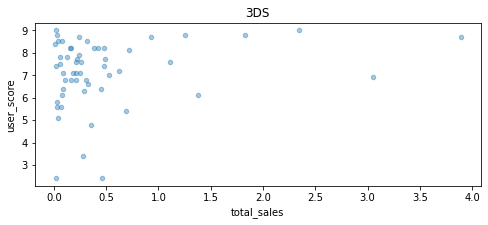

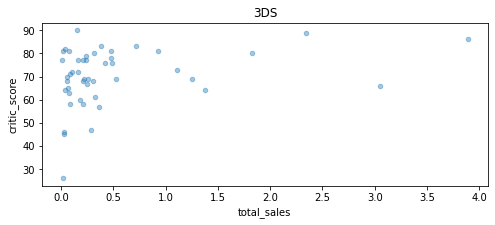

Платформа: XOne
Корреляция зависимости от оценки пользователей -0.09
Корреляция зависимости от оценки критиков 0.42


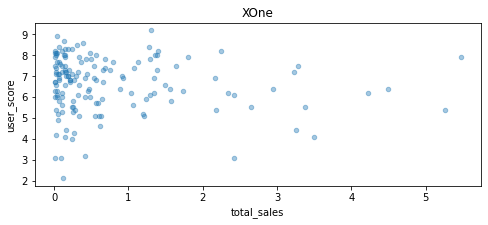

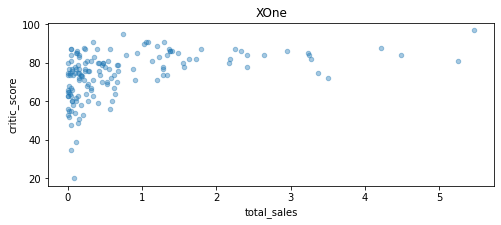

Платформа: WiiU
Корреляция зависимости от оценки пользователей 0.41
Корреляция зависимости от оценки критиков 0.38


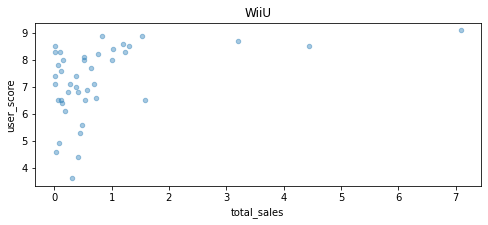

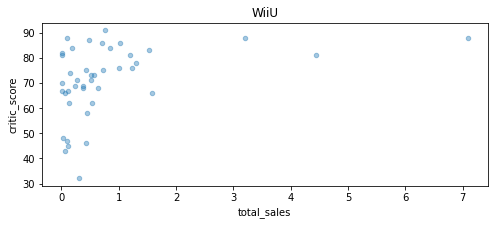

Платформа: PS3
Корреляция зависимости от оценки пользователей 0.16
Корреляция зависимости от оценки критиков 0.45


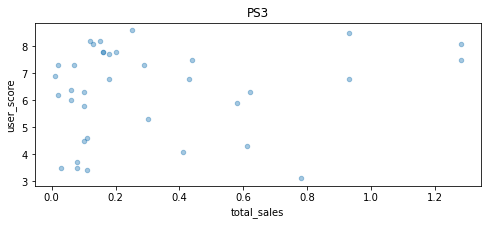

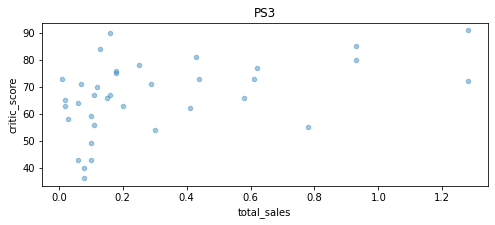

Платформа: X360
Корреляция зависимости от оценки пользователей 0.34
Корреляция зависимости от оценки критиков 0.53


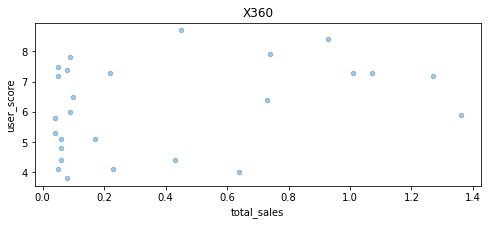

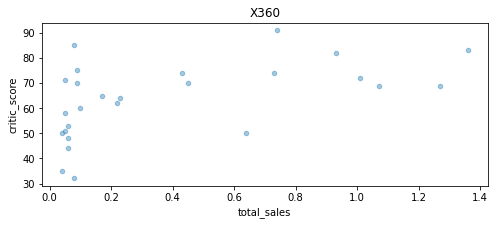

In [17]:
platform_sales_top_5 = platform_sales_top[
    platform_sales_top['platform'] != 'PS4'].sort_values(by='total_sales', ascending=False).head(5)

data_s_t = data[data['year_of_release'] > 2013].query(
    'platform in @platform_sales_top_5.platform')

d = data_s_t['platform'].unique()

for p in d:
    data_s_t = data_s_t[data_s_t['user_score'] != -1]
    data_s_t.query('platform == @p').plot(
        x='total_sales', y='user_score', kind='scatter', alpha=0.4,  figsize=(8,3), title= p )
                
    data_s_t = data_s_t[data_s_t['critic_score'] != -1]
    data_s_t.query('platform == @p').plot(
        x='total_sales', y='critic_score', kind='scatter', alpha=0.4,  figsize=(8,3), title= p )
    print('Платформа:', p)
    print('Корреляция зависимости от оценки пользователей', data_s_t.query('platform == @p')['user_score'].corr(
        data_s_t['total_sales']).round(decimals=2))
    print('Корреляция зависимости от оценки критиков', data_s_t.query('platform == @p')['critic_score'].corr(
        data_s_t.query('platform == @p')['total_sales']).round(decimals=2))
    plt.show()

Корреляция зависимости от оценки, у топовых платформ достаточно разная. Зависимость от оценки критиков выглядит убедительнее, чем зависимости от оценки пользователей, хоть и не у всех платформ. У японской Nintendo 3DS зависимости одинаковые: 0.28. А у американской Xbox One корреляция зависимости от оценки критиков средняя и положительная: 0.42. А зависимость от оценки пользователей отрицательная -0.09, то есть оценка уменьшается, а продажи растут. Значения корреляции у платформы PS4 ближе всего к XOne, два топа с похожими закономерностями.
Посмотрим на общее распределение игр по жанрам.

,genre,total_sales
0,Action,199.36
8,Shooter,170.94
10,Sports,109.48
7,Role-Playing,101.44
3,Misc,37.55


Text(0.5, 1.0, 'продажи по жанрамм')

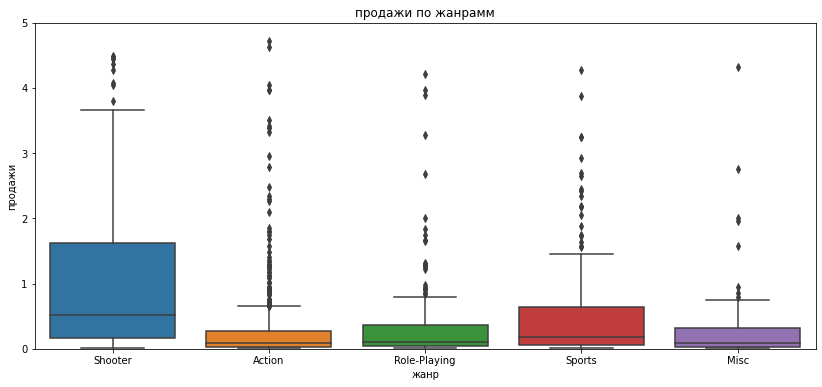

In [18]:
data_top = data[data['year_of_release'] > 2013]
genre_top_sales = data_top.groupby('genre').agg({'total_sales':'sum'}).reset_index().sort_values(
    by='total_sales', ascending= False ).head()
display(genre_top_sales)
data_top = data_top.query('genre in @genre_top_sales.genre')
plt.figure(figsize=(14,6))
plt.ylim(0,5)
sns.boxplot(data=data_top, x='genre', y='total_sales')
plt.xlabel('жанр')
plt.ylabel('продажи')
plt.title('продажи по жанрамм')

Самыми прибыльными жанрами являются Action и Shooter. На графике видно, что жанр Shooter имеет самый широкий межквартильный размах и самое высокое медианное значение. Несмотря на то, что общие продажи у этого жанра меньше, чем у жанра Action, можно сказать, что он имеет более устойчивый спрос на всех платформах. Вероятно, жанр Action показывает высокие продажи благодаря топовым играм и играм на конкретных платформах. Тоже самое можно сказать и про остальные жанры. Спортивные и ролевые игры примерно на одном уровне около 100 миллионов проданных копий.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 В проекте под "прибыльностью" понимается наличие устойчивого спроса пользователей на данный жанр. Можно сделать уникальный сюжет, быстрый движок, красивую графику и вложить немеряно денег в рекламу и продажи игры подпрыгнут. Но нам лучше выбирать игру из жанра, на которой есть постоянный спрос независимо от маркетинговых усилий производителей игр.<br>
Это хороший пример, когда на одних и тех же данных разные диаграммы дают разный анализ. Визуализация это не только красивое представление табличных данных, а еще и инструмент анализа.</font>

# Шаг 4. Составим портрет пользователя каждого региона

Посмотрим на топ 5 платформ по регионам.

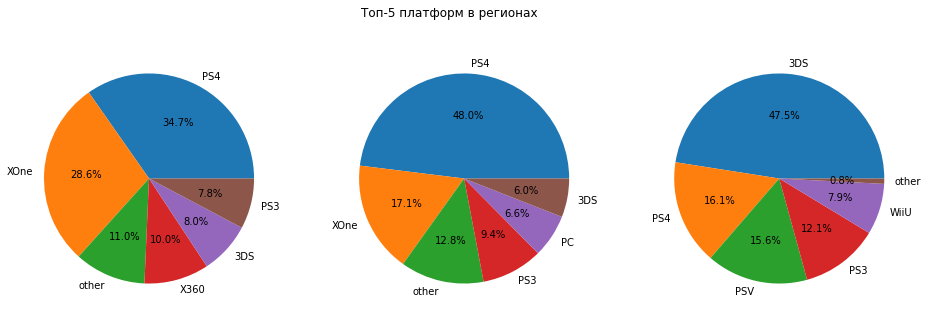

In [20]:
data= data[data['year_of_release'] > 2013]
data_na_sales = data.groupby(by='platform').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False)
data_na_sales.loc['other', 'na_sales'] = data_na_sales.iloc[5:].sum()[0]
data_na_sales_top = data_na_sales.sort_values(by='na_sales', ascending=False).head(6).reset_index()

data_eu_sales = data.groupby(by='platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False)
data_eu_sales.loc['other', 'eu_sales'] = data_eu_sales.iloc[5:].sum()[0]
data_eu_sales_top = data_eu_sales.sort_values(by='eu_sales', ascending=False).head(6).reset_index()

data_jp_sales = data.groupby(by='platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False)
data_jp_sales.loc['other', 'jp_sales'] = data_jp_sales.iloc[5:].sum()[0]
data_jp_sales_top = data_jp_sales.sort_values(by='jp_sales', ascending=False).head(6).reset_index()


fig = plt.figure(figsize=(16, 5))
fig.suptitle('Топ-5 платформ в регионах')
plt.subplot(1, 3, 1)
plt.pie(data = data_na_sales_top, x= 'na_sales', autopct='%1.1f%%', labels = data_na_sales_top['platform'])
plt.subplot(1, 3, 2)
plt.pie(data = data_eu_sales_top, x= 'eu_sales', autopct='%1.1f%%', labels = data_eu_sales_top['platform'])
plt.subplot(1, 3, 3)
plt.pie(data = data_jp_sales_top, x= 'jp_sales', autopct='%1.1f%%', labels = data_jp_sales_top['platform'])
plt.show()

 - В Северной америке предпочитают играть в PlayStation 4 и Xbox One.
 - В Европе с большим отрывом лидирует PlayStation 4.
 - В Японии самой популярной приставкой является родная им Nintendo 3DS.

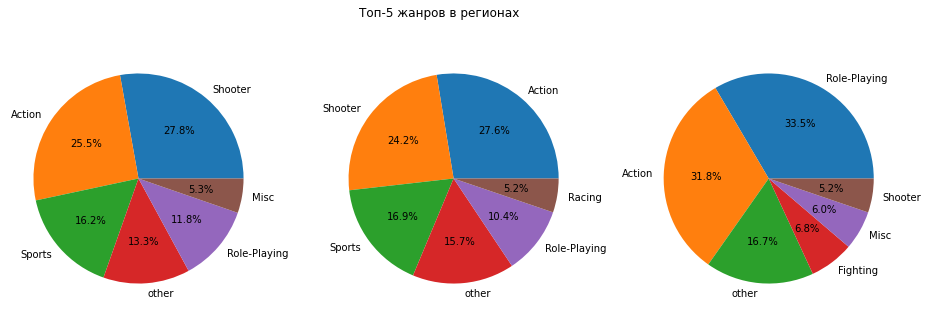

In [21]:
data_na_sales = data.groupby(by='genre').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False)
data_na_sales.loc['other', 'na_sales'] = data_na_sales.iloc[5:].sum()[0]
data_na_sales_top = data_na_sales.sort_values(by='na_sales', ascending=False).head(6).reset_index()

data_eu_sales = data.groupby(by='genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False)
data_eu_sales.loc['other', 'eu_sales'] = data_eu_sales.iloc[5:].sum()[0]
data_eu_sales_top = data_eu_sales.sort_values(by='eu_sales', ascending=False).head(6).reset_index()

data_jp_sales = data.groupby(by='genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False)
data_jp_sales.loc['other', 'jp_sales'] = data_jp_sales.iloc[5:].sum()[0]
data_jp_sales_top = data_jp_sales.sort_values(by='jp_sales', ascending=False).head(6).reset_index()


fig = plt.figure(figsize=(16, 5))
fig.suptitle('Топ-5 жанров в регионах')
plt.subplot(1, 3, 1)
plt.pie(data = data_na_sales_top, x= 'na_sales', autopct='%1.1f%%', labels = data_na_sales_top['genre'])
plt.subplot(1, 3, 2)
plt.pie(data = data_eu_sales_top, x= 'eu_sales', autopct='%1.1f%%', labels = data_eu_sales_top['genre'])
plt.subplot(1, 3, 3)
plt.pie(data = data_jp_sales_top, x= 'jp_sales', autopct='%1.1f%%', labels = data_jp_sales_top['genre'])
plt.show()

 - В Северной америке предпочитают игры в жанрах Shooter и Action.
 - В Европе тоже больше играют в Shooter и Action, но в Action больше. 
 - В Японии самыми популярными жанрами игр являются Role-Playing и Action, почти одинаково.
    
Посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

<AxesSubplot:xlabel='rating', ylabel='na_sales'>

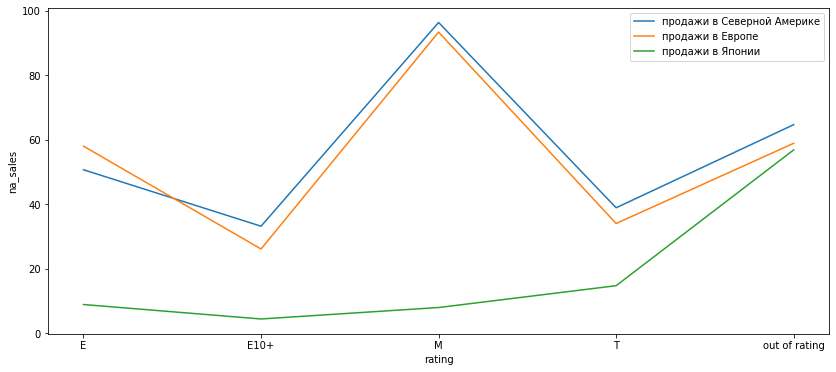

In [23]:
data_r = data.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(data=data_r, x='rating', y='na_sales', label = 'продажи в Северной Америке')
sns.lineplot(data=data_r, x='rating', y='eu_sales', label = 'продажи в Европе')
sns.lineplot(data=data_r, x='rating', y='jp_sales', label = 'продажи в Японии')

На графике видно, что рейтинг ESRB не оказывает особого влияния на продажи в отдельных регионах: Северная Америкеа и Европа, значения расположены параллельно. Рейтинг М (17+) - самый популярный. В Японии игры с рейтингом "out of rating", то есть без рейтинга, лидируют по продажам, а остальные имеют небольшие значения. Дело в том, что игры, выпущенные в Японии, оцениваются другой организацией - Computer Entertainment Rating Organization (CERO).

# Шаг 5. Проверим гипотезы

Проверим гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Поскольку эта гипотеза об отсутствии различий, обозначим её нулевой: H0. Соответственно, альтернативной гипотезой H1 будет: средний пользовательский рейтинг платформ Xbox One и PC различается. Так как нужно определить статистическую значимость различий средних величин, используем t-критерий. Воспользуемся методом scipy.stats.ttest_1samp, установим критический уровень статистической значимости 5%.

- H0: средний пользовательский рейтинг платформ Xbox One и PC одинаковый
- H1: средний пользовательский рейтинг платформ Xbox One и PC различается

In [24]:
data_top = data[data['user_score'] != -1]

alpha = 0.05

xone = data_top[data_top['platform'] == 'XOne']['user_score']
pc = data_top[data_top['platform'] == 'PC']['user_score']


results = st.ttest_ind(xone, pc, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('Cредний пользовательский рейтинг платформ Xbox One:', xone.mean().round(3),
      '\n' 'Cредний пользовательский рейтинг платформ PC:', pc.mean().round(3))    

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу
Cредний пользовательский рейтинг платформ Xbox One: 6.595 
Cредний пользовательский рейтинг платформ PC: 6.298


Полученное значение явно выше критического уровня статистической значимости.
Вероятность относительно высока — данные не противоречат гипотезе.

Проверим гипотезу: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Поскольку гипотеза об отсутствии различий - средний пользовательский рейтинг жанров Action и Sports одинаковый, обозначим её нулевой: H0. Соответственно, альтернативной гипотезой H1 будет: средний пользовательский рейтинг жанров Action и Sports различается. Так как нужно определить статистическую значимость различий средних величин, используем t-критерий. Воспользуемся методом scipy.stats.ttest_1samp, установим критический уровень статистической значимости 5%.
- H0: средний пользовательский рейтинг жанров Action и Sports одинаковый
- H1: средний пользовательский рейтинг жанров Action и Sports различается

In [25]:
data_top = data[data['year_of_release'] > 2013]
data_top = data_top[data_top['user_score'] != -1]

alpha = 0.05

action = data_top[data_top['genre'] == 'Action']['user_score']
sports = data_top[data_top['genre'] == 'Sports']['user_score']


results = st.ttest_ind(action, sports, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('Cредний пользовательский рейтинг жанра Action:', action.mean().round(3),
      '\n' 'Cредний пользовательский рейтинг жанра Sports:', sports.mean().round(3))

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу
Cредний пользовательский рейтинг жанра Action: 6.761 
Cредний пользовательский рейтинг жанра Sports: 5.225


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

# Шаг 6. Общий вывод
Компьютерные игры достаточно популярны и их продажи показывают огромные цифры. Но на фоне периода с начала 2000-х по начало 2010-х картина уже не выглядит такой грандиозной. Однако, исходя из данных, индустрия все ещё вполне жива, и покупательская способность очевидна. Игры всё ещё активно выпускаются, а люди продолжают в них играть.

Рекомендации:
- обязательно учитывать популярность платформы в выбранном регионе:
    - Северная Америка и Европа - PlayStation 4 и Xbox One
    - Япония - Nintendo 3DS и PlayStation 4
    
    
- обязательно учитывать популярность жанра:
    - Северная Америка и Европа - Shooter и Action
    - Япония - Role-Playing и Action
    
    
- учитывать влияние оценок критиков:
    - выше оценка - больше продажи
    
    
- учитывать популярность рейтинга M (17+) ESRB в Северной Америке и Европе  
    
- проводить повторный анализ данных не менее чем раз в три года

- собирать информацию за актуальный период

- при сборе информации более детально учитывать присвоение рейтинга в регионах